# Module import

In [1]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3193637 sha256=7b9fa3fda180c2a398245168857f269cde3c0873bc3a8ac6fc16fd1c67c498a7
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

# Data Load

- userId : 사용자 ID
- movieId : 영화 ID
- rating : 별점(0.5 stargs ~ 5.0 stars)
- timestamp : [midnight Coordinated Universal Time (UTC) of January 1, 1970] 이후로의 시간(second)

In [8]:
data = pd.read_csv('/content/drive/MyDrive/투빅스 연합동아리/ml-latest-small/ratings.csv')
display(data)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


# EDA

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


## 결측치 확인

In [10]:
print(f"데이터 개수 : {len(data)}")
print(len(data) - data.count())

데이터 개수 : 100836
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


## 별점 비율 시각화

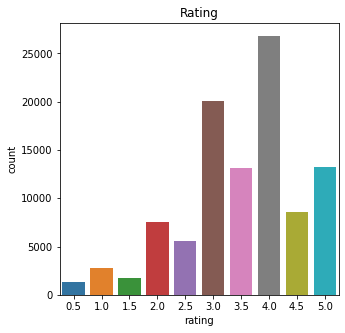

In [11]:
plt.figure(figsize = (5,5))
sns.countplot(x = data['rating'])
plt.title('Rating')
plt.show()

# 컨텐츠 필터링 (Content-based Filtering)

In [23]:
# data의 userID 와 movieID가 0부터 시작할 수 있도록 조정
data.iloc[:,0] -= 1
data.iloc[:,1] -= 1

In [24]:
data

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,2,4.0,964981247
2,0,5,4.0,964982224
3,0,46,5.0,964983815
4,0,49,5.0,964982931
...,...,...,...,...
100831,609,166533,4.0,1493848402
100832,609,168247,5.0,1493850091
100833,609,168249,5.0,1494273047
100834,609,168251,5.0,1493846352


In [26]:
n_users = np.max(data.iloc[:, 0])     # 총 유저 수
n_movies = np.max(data.iloc[:,1])     # 총 영화 개수
shape = (n_users + 1, n_movies + 1)  # 위에서 0부터 시작하므로 1씩 다시 더하기
shape

(610, 193609)

In [49]:
# 인접행렬 구하기
adj_matrix = np.ndarray(shape, dtype=int)
for user_id, movie_id, rating, time in data.values:
    adj_matrix[int(user_id)][int(movie_id)] = 1.  # 영화를 봤는지 안봤는지에 대한 여부를 0과 1로 출력

# 1이 있는 위치 == 데이터가 있는 위치
adj_matrix  

array([[1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

- dot product를 통해 다른 사용자들과의 유사도 계산
- 나와 가장 높은 유사도를 가진 사용자의 시청 목록 추천

In [50]:
my_id, my_vector = 0, adj_matrix[0]
best_match, best_match_id, best_match_vector = -1, -1, []

for user_id, user_vector in enumerate(adj_matrix): # 인접행렬에서 하나씩 행을 가져와 비교한다.
    if my_id != user_id: # 현재 ID와 비교하고자 하는 ID는 달라야한다.
        similarity = np.dot(my_vector, user_vector) # 현재 vector와 비교하고자 하는 vector를 dot product하여 유사도를 계산한다.
                                                    # 현재 adj_matrix에는 데이터가 있는 위치에만 1이 있기때문에 유사도 계산에 dot product를 사용함을 볼 수 있음

        if similarity > best_match: # 만약 구한 유사도의 값이 기존의 best 유사도보다 높다면 값을 새로 갱신한다.
            best_match = similarity
            best_match_id = user_id
            best_match_vector = user_vector


print(f"Best Match : {best_match}, Best Match ID : {best_match_id}")

Best Match : 200, Best Match ID : 413


In [51]:
recommend_list = []

for i, log in enumerate(zip(my_vector, best_match_vector)):
    log1, log2 = log

    # 나는 보지 않지만 나와 가장 잘 맞는 사용자는 시청하는 영화에 대해서 추천
    if log1 < 1. and log2 > 0.:
        recommend_list.append(i)

# 나는 보지 않았지만 413번은 본 영화 리스트 추천
print(recommend_list)

[1, 4, 6, 7, 9, 10, 14, 15, 16, 17, 20, 21, 22, 23, 24, 26, 30, 31, 33, 35, 38, 41, 43, 44, 45, 47, 51, 53, 56, 61, 64, 70, 71, 74, 77, 80, 85, 87, 88, 91, 93, 94, 103, 106, 110, 111, 117, 118, 121, 124, 134, 140, 143, 144, 146, 149, 152, 154, 157, 158, 159, 160, 161, 164, 165, 167, 169, 171, 172, 173, 174, 175, 178, 179, 184, 187, 190, 192, 195, 197, 204, 206, 207, 208, 209, 214, 217, 221, 223, 224, 227, 229, 232, 235, 241, 246, 248, 250, 251, 252, 256, 258, 260, 261, 265, 266, 272, 275, 276, 279, 281, 287, 289, 290, 291, 292, 299, 302, 307, 311, 313, 314, 317, 318, 321, 324, 326, 328, 336, 337, 338, 339, 341, 343, 344, 345, 347, 349, 351, 352, 354, 356, 357, 360, 363, 367, 371, 372, 373, 376, 378, 379, 381, 382, 385, 407, 411, 412, 413, 414, 415, 416, 419, 420, 426, 427, 428, 430, 431, 433, 435, 437, 439, 441, 443, 447, 449, 452, 453, 457, 458, 463, 465, 470, 473, 474, 476, 478, 480, 481, 484, 486, 489, 490, 492, 493, 496, 503, 506, 507, 510, 513, 515, 516, 518, 520, 523, 528, 532, 5

- 유클리드 거리를 사용해 유사도 구하기
- 거리 기반이므로 값이 작을 수록 유사도가 높음

In [52]:
my_id, my_vector = 0, adj_matrix[0]
best_match, best_match_id, best_match_vector = 9999, -1, []  # 이번에는 유사도가 높을 수록 best_match 거리가 짧아지기에 9999를 초기값으로 넣어줌줌

for user_id, user_vector in enumerate(adj_matrix): 
    if my_id != user_id:
        euclidean_dist = np.sqrt(np.sum(np.square(my_vector - user_vector))) # 위에서 사용한 dot product 대신 Euclidean 거리를 사용용

        if euclidean_dist < best_match:  # 거리 기반이므로 유사도가 높다는 것은 거리가 더 작은 것 -> 부등호 방향 반대대
            best_match = euclidean_dist
            best_match_id = user_id
            best_match_vector = user_vector


print(f"Best Match : {best_match}, Best Match ID : {best_match_id}")

Best Match : 15.0996688705415, Best Match ID : 163


In [55]:
recommend_list = []

for i, log in enumerate(zip(my_vector, best_match_vector)):
    log1, log2 = log

    # 나나는 보지 않지만 나와 가장 잘 맞는 사용자는 시청하는 영화에 대해서 추천
    if log1 < 1. and log2 > 0.:
        recommend_list.append(i)

# 나는 보지 않았지만 163번은 본 영화 리스트 추천
print(recommend_list)

[588, 1035, 1046, 1100, 1199, 1200, 1355, 1526, 1922, 2052, 2166, 3403, 3653, 3995, 4022, 4439]


- cosine 유사도를 사용해 유사도 계산

In [54]:
def compute_cos_similarity(v1, v2):
    norm1 = np.sqrt(np.sum(np.square(v1)))
    norm2 = np.sqrt(np.sum(np.square(v2)))
    
    dot = np.dot(v1, v2)
    
    return dot / (norm1 * norm2)

In [56]:
my_id, my_vector = 0, adj_matrix[0]
best_match, best_match_id, best_match_vector = -1, -1, []  # 코사인 유사도의 경우 유사도가 높을 수록 best_match값이 커지므로 다시 -1로 초기화

for user_id, user_vector in enumerate(adj_matrix): 
    if my_id != user_id:
        cos_similarity = compute_cos_similarity(my_vector, user_vector)

        if cos_similarity > best_match:  # 코사인 유사도 값이 클 수록 더 유사함 -> 다시 부등호 방향 반대대
            best_match = cos_similarity
            best_match_id = user_id
            best_match_vector = user_vector


print(f"Best Match : {best_match}, Best Match ID : {best_match_id}")

Best Match : 0.38097837645537314, Best Match ID : 312


In [57]:
recommend_list = []

for i, log in enumerate(zip(my_vector, best_match_vector)):
    log1, log2 = log

    # 나나는 보지 않지만 나와 가장 잘 맞는 사용자는 시청하는 영화에 대해서 추천
    if log1 < 1. and log2 > 0.:
        recommend_list.append(i)

# 나는 보지 않았지만 312번은 본 영화 리스트 추천
print(recommend_list)

[9, 28, 31, 38, 75, 164, 169, 171, 187, 195, 252, 292, 317, 331, 352, 376, 378, 379, 381, 404, 441, 473, 511, 518, 540, 588, 609, 736, 749, 857, 865, 879, 911, 919, 923, 967, 990, 998, 1035, 1036, 1046, 1058, 1124, 1128, 1198, 1199, 1211, 1214, 1220, 1234, 1246, 1248, 1260, 1273, 1284, 1286, 1300, 1319, 1338, 1343, 1344, 1346, 1349, 1355, 1370, 1371, 1373, 1374, 1375, 1386, 1390, 1393, 1404, 1448, 1465, 1479, 1512, 1589, 1590, 1602, 1607, 1609, 1638, 1652, 1689, 1716, 1747, 1753, 1881, 1884, 1908, 1922, 1967, 1973, 1993, 1996, 2000, 2001, 2002, 2003, 2005, 2010, 2019, 2020, 2022, 2033, 2042, 2052, 2075, 2079, 2086, 2096, 2099, 2108, 2116, 2137, 2139, 2166, 2274, 2286, 2301, 2310, 2362, 2375, 2376, 2406, 2408, 2454, 2466, 2512, 2526, 2529, 2530, 2531, 2532, 2552, 2642, 2663, 2709, 2727, 2745, 2746, 2761, 2790, 2797, 2818, 2866, 2870, 2900, 2917, 2967, 2985, 3031, 3080, 3113, 3152, 3174, 3209, 3255, 3261, 3266, 3395, 3420, 3437, 3470, 3480, 3534, 3549, 3554, 3637, 3687, 3688, 3692, 3696,

# 협엽 필터링 (Collaborative Filtering)

In [63]:
from surprise import KNNBasic, SVD, SVDpp, NMF
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

In [60]:
data = pd.read_csv('/content/drive/MyDrive/투빅스 연합동아리/ml-latest-small/ratings.csv')
data

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


- KNN 사용

In [65]:
# Surprise 라이브러리를 위한 데이터 변환
reader = Reader(rating_scale=(data["rating"].min(), data["rating"].max()))
data = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)

# 모델 생성 및 교차 검증
model = KNNBasic()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9451  0.9506  0.9465  0.9494  0.9433  0.9470  0.0027  
MAE (testset)     0.7235  0.7235  0.7277  0.7276  0.7260  0.7257  0.0019  
Fit time          0.36    0.29    0.27    0.27    0.19    0.28    0.05    
Test time         3.83    3.98    3.95    4.04    1.99    3.56    0.79    


{'test_rmse': array([0.94511203, 0.95061523, 0.94646826, 0.94944121, 0.94328773]),
 'test_mae': array([0.72351378, 0.72351517, 0.72766083, 0.72764284, 0.72602281]),
 'fit_time': (0.36282968521118164,
  0.2901883125305176,
  0.2742278575897217,
  0.2732856273651123,
  0.19499659538269043),
 'test_time': (3.8293235301971436,
  3.9814302921295166,
  3.9511990547180176,
  4.035719156265259,
  1.9940266609191895)}

- SVD 사용

In [66]:
model = SVD()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8757  0.8672  0.8733  0.8743  0.8737  0.8728  0.0029  
MAE (testset)     0.6732  0.6666  0.6723  0.6712  0.6728  0.6712  0.0024  
Fit time          3.37    3.63    3.93    3.91    1.78    3.32    0.80    
Test time         0.72    0.78    0.58    0.51    0.27    0.57    0.18    


{'test_rmse': array([0.87565476, 0.86721804, 0.87327698, 0.87432045, 0.87368572]),
 'test_mae': array([0.67318985, 0.66660674, 0.67226918, 0.67120186, 0.67283576]),
 'fit_time': (3.3665096759796143,
  3.6305031776428223,
  3.9299378395080566,
  3.906745195388794,
  1.7755513191223145),
 'test_time': (0.7170157432556152,
  0.78244948387146,
  0.5813758373260498,
  0.5071606636047363,
  0.2675590515136719)}

- NMF 사용

In [67]:
model = NMF()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9341  0.9181  0.9239  0.9271  0.9204  0.9247  0.0056  
MAE (testset)     0.7165  0.7016  0.7078  0.7078  0.7057  0.7079  0.0049  
Fit time          8.14    7.74    7.86    8.27    4.32    7.26    1.49    
Test time         0.95    0.69    1.11    0.86    0.12    0.75    0.34    


{'test_rmse': array([0.93406283, 0.91812105, 0.92388233, 0.92713927, 0.92041689]),
 'test_mae': array([0.71648855, 0.70159679, 0.70784397, 0.70780554, 0.7056991 ]),
 'fit_time': (8.140886545181274,
  7.735090970993042,
  7.8571553230285645,
  8.272013187408447,
  4.316194772720337),
 'test_time': (0.9523642063140869,
  0.687659740447998,
  1.1117644309997559,
  0.8580682277679443,
  0.12325096130371094)}

- SVD++ 사용

In [68]:
model = SVDpp()
cross_validate(model, data, measures=['rmse', 'mae'], cv=5, n_jobs=4, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8631  0.8640  0.8641  0.8588  0.8578  0.8616  0.0027  
MAE (testset)     0.6609  0.6599  0.6639  0.6583  0.6599  0.6606  0.0019  
Fit time          305.25  310.15  308.49  308.28  86.33   263.70  88.70   
Test time         36.59   37.71   38.62   37.40   10.13   32.09   11.00   


{'test_rmse': array([0.86312038, 0.86399864, 0.8640582 , 0.85880369, 0.85779917]),
 'test_mae': array([0.6609292 , 0.65985417, 0.66388108, 0.65828315, 0.65988721]),
 'fit_time': (305.24982380867004,
  310.14780950546265,
  308.48890829086304,
  308.2811133861542,
  86.32581901550293),
 'test_time': (36.59451913833618,
  37.70973825454712,
  38.61676549911499,
  37.39781308174133,
  10.12889552116394)}